# Introduction to Data Science
## Text classification
Author: Robert Moakler
***

Read in some packages.

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

np.random.seed(36)

# We will want to keep track of some different roc curves, lets do that here
tprs = []
fprs = []
roc_labels = []

### Data
We have a new data set in `data/spam_ham.csv`. Let's take a look at what it contains.

In [8]:
!head -2 C:/Users/kevin/Documents/GitHub/DS_course/datasets/spam_ham.csv

text,spam
'Hi...I have to use R to find out the 90\% confidence-interval for the sensitivityand specificity of the following diagnostic test:A particular diagnostic test for multiple sclerosis was conducted on 20 MSpatients and 20 healthy subjects, 6 MS patients were classified as healthyand 8 healthy subjects were classified as suffering from the MS.Furthermore, I need to find the number of MS patients required for asensitivity of 1\%...Is there a simple R-command which can do that for me?I am completely new to R...Help please!Jochen-- View this message in context: http://www.nabble.com/Confidence-Intervals....-help...-tf3544217.html#a9894014Sent from the R help mailing list archive at Nabble.com.______________________________________________R-help@stat.math.ethz.ch mailing listhttps://stat.ethz.ch/mailman/listinfo/r-helpPLEASE do read the posting guide http://www.R-project.org/posting-guide.html',ham


Looks like we have two features: some text (looks like an email), and a label for spam or ham. What is the distribution of the target variable?

In [9]:
!cut -f2 -d',' C:/Users/kevin/Documents/GitHub/DS_course/datasets/spam_ham.csv | sort | uniq -c | head

      1 
      1                  Alonzo Houser
      1                  Andrea Winslow
      1                  Arron Tanner
      1                  Becky Conklin
      1                  Christie Slaughter
      1                  Danial Good
      1                  Darcy Berger
      1                  Dena Major
      1                  Donna Henderson


uniq: write error: Illegal seek


It doesn't look like that did what we wanted. Can you see why?

The data in this file has **text data**. The text data in the first column can have commas. The command line will have some issues reading this data since it will try to split on all instances of the delimeter. Ideally, we would like to have a way of **encapsulating** the first column. Note that we actually have something like this in the data. The first column is wrapped in single quotes. Python (and pandas) have more explicit ways of dealing with this:

In [7]:
data = pd.read_csv("C:/Users/kevin/Documents/GitHub/DS_course/datasets/spam_ham.csv", quotechar="'", escapechar="\\")

Above, we specify that fields that need to be encapsulated are done so with single quotes (`quotechar`). But, what if the text in this field uses single quotes? For example, apostrophes in words like "can't" would break the encapsulation. To overcome this, we **escape** single quotes that are actually just text. Here, we specify the escape character as a backslash (`escapechar`). So now, for example, "can't" would be written as "can\'t".

Let's take another look at our data.

In [10]:
data.head()

,text,spam
0,Hi...I have to use R to find out the 90% confi...,ham
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",ham
2,Stephen Thorne wrote:> What I was thinking was...,ham
3,"Hi,I have this site that auto generates an ind...",ham
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,ham


Here, the target is whether or not a record should be considered as spam. This is recorded as the string 'spam' or 'ham'. To make it a little easier for our classifier, let's recode it as `0` or `1`.

In [11]:
data['spam'] = pd.Series(data['spam'] == 'spam', dtype=int)

In [12]:
data.head()

,text,spam
0,Hi...I have to use R to find out the 90% confi...,0
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",0
2,Stephen Thorne wrote:> What I was thinking was...,0
3,"Hi,I have this site that auto generates an ind...",0
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,0


Since we are going to do some modeling, we should split our data into a training and test set.

In [13]:
X = data['text']
Y = data['spam']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

### Text as features
How can we turn the large amount of text for each record into useful features?


#### Binary representation
One way is to create a matrix that uses each word as a feature and keeps track of whether or not a word appears in a document/record. You can do this in sklearn with a `CountVectorizer()` and setting `binary` to `true`. The process is very similar to how you fit a model: you will fit a `CounterVectorizer()`. This will figure out what words exist in your data.

In [14]:
binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Let's look at the vocabulary the `CountVectorizer()` learned.

In [16]:
list(binary_vectorizer.vocabulary_.keys())[0:10]

['677',
 'hashe',
 'executedfrom',
 '22195',
 'drugmakeris',
 'bee',
 'reallydoes',
 'kreneskyanalyst',
 'orelectronic',
 'tttt']

Now that we know what words are in the data, we can transform our blobs of text into a clean matrix. Simply `.transform()` the raw data using our fitted `CountVectorizer()`. You will do this for the training and test data. What do you think happens if there are new words in the test data that were not seen in the training data?

In [17]:
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

We can take a look at our new `X_test_counts`.

In [18]:
X_test_binary

<2028x71157 sparse matrix of type '<class 'numpy.int64'>'
	with 225416 stored elements in Compressed Sparse Row format>

Sparse matrix? Where is our data?

If you look at the output above, you will see that it is being stored in a *sparse* matrix (as opposed to the typical dense matrix) that is ~2k rows long and ~70k columns. The rows here are records in the original data and the columns are words. Given the shape, this means there are ~140m cells that should have values. However, from the above, we can see that only ~220k cells (~0.15%) of the cells have values! Why is this?

To save space, sklearn uses a sparse matrix. This means that only values that are not zero are stored! This saves a ton of space! This also means that visualizing the data is a little trickier. Let's look at a very small chunk.

In [19]:
X_test_binary[0:20, 0:20].todense()

matrix([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0,

#### Applying a model
Now that we have a ton of features (since we have a ton of words!) let's try using a logistic regression model to predict spam/ham.

In [22]:
model = LogisticRegression()
model.fit(X_train_binary, Y_train)

print("Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_binary), Y_test))

Area under the ROC curve on the test data = 0.996


Is this any good? What do we care about in this case? Let's take a look at our ROC measure in more detail by looking at the actual ROC curve.

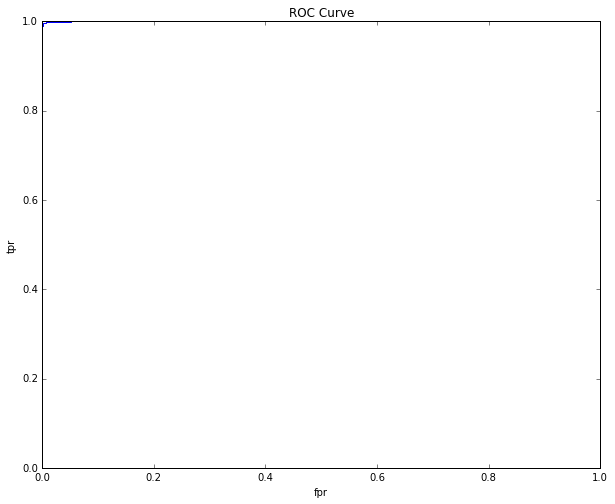

In [23]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Binary")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

#### Counts instead of binary
Instead of using a 0 or 1 to represent the occurence of a word, we can use the actual counts. We do this the same way as before, but now we leave `binary` set to `false` (the default value).

In [25]:
# Fit a counter
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_counts, Y_train)

print("Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_counts), Y_test))

Area under the ROC curve on the test data = 0.995


We can also take a look at the ROC curve.

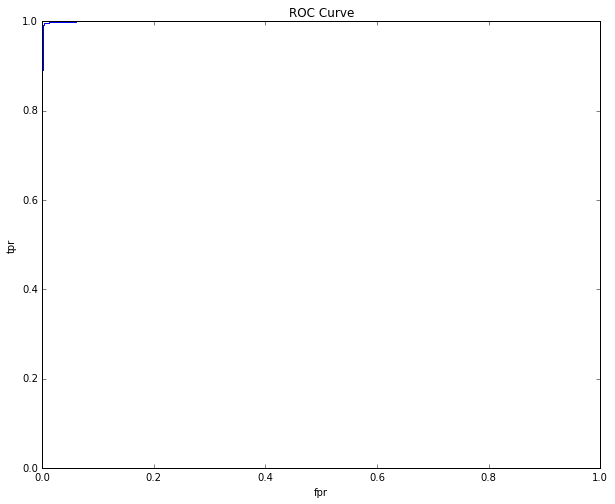

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_counts)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Counts")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

#### Tf-idf
Another popular technique when dealing with text is to use the term frequency - inverse document frequency (tf-idf) measure.

In [27]:
# Fit a counter
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform to a counter
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

print("Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_counts), Y_test))

Area under the ROC curve on the test data = 0.986


Once again, we can look at the ROC curve.

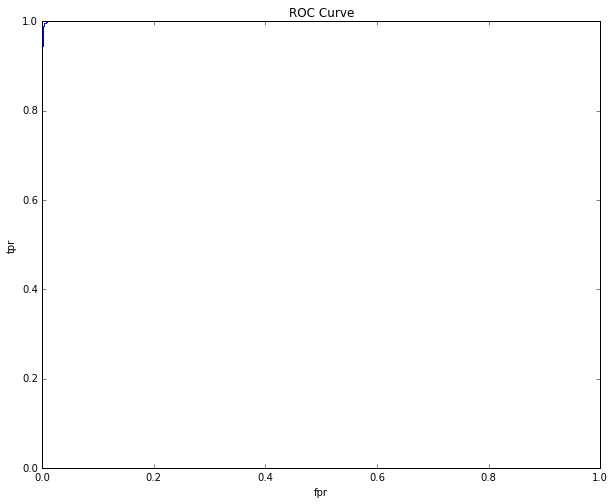

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Tfidf")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

The `CountVectorizer()` and `TfidfVectorizer()` functions have many options. You can restrict the words you would like in the vocabulary. You can add n-grams. You can use stop word lists. Which options you should use generally depend on the type of data you are dealing with. We can discuss and try some of them now.

Now that we have a few different feature sets and models, let's look at all of our ROC curves.

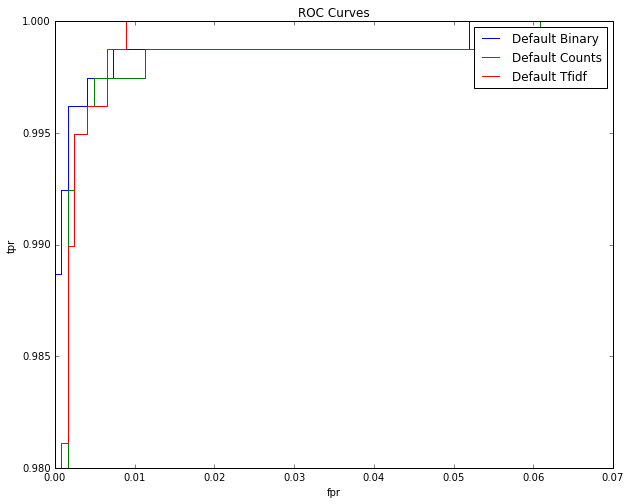

In [29]:
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()
plt.xlim([0, .07])
plt.ylim([.98, 1])
plt.show()

#### *A note on cross validation*
We didn't use cross validation here, but it is definitely possible. The code is a little messier, so we will leave this to a Forum discussion.

### Naive Bayes
So far we have been exposed to tree classifiers and logistic regression in class. We have also seen SVMs in the homwork. A popular modeling technique (especially in text classification) is the is the (Bernoulli) naive Bayes classifier.

Using this model in sklearn is just as easy as all the other models.

In [30]:
model = BernoulliNB()
model.fit(X_train_tfidf, Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [31]:
print("AUC on the count data = %.3f" % metrics.roc_auc_score(model.predict(X_test_tfidf), Y_test))

AUC on the count data = 0.976


The past few weeks we have seen that many of the models we are using have different parameters that can be tweaked. In naive Bayes, the parameter that is typically tuned is the Laplace smoothing value `alpha`. We won't discuss this in class, but will post a discussion on the NYU Classes Forum.  Also, there is another version of naive Bayes (not discussed in the book) called multinomial naive Bayes, which can handle count features and not just binary features.  We will give an additional reading covering that (in the Forum as well).  